# Interresolution figure

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cf_xarray
import cmocean as cm

In [15]:
# Import the data (names generalised to use for both comparisons)
data_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_anom_pan01.nc', chunks = 'auto')
data_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_anom_pan005.nc', chunks = 'auto')

In [16]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [17]:
# Land and contour data
shelf_contour_1 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
shelf_contour_2 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
land_1 = xr.where(np.isnan(depth_1.rename('land_1')), 1, np.nan)
depth_1_shelf, shelf_contour_1 = shelf_mask_isobath(depth_1, 'mom6_01')

depth_2 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho']
land_mask_2 = (0 * depth_2).fillna(1)
land_2 = xr.where(np.isnan(depth_2.rename('land_2')), 1, np.nan)
depth_2_shelf, shelf_contour_2 = shelf_mask_isobath(depth_2, 'mom6_005')

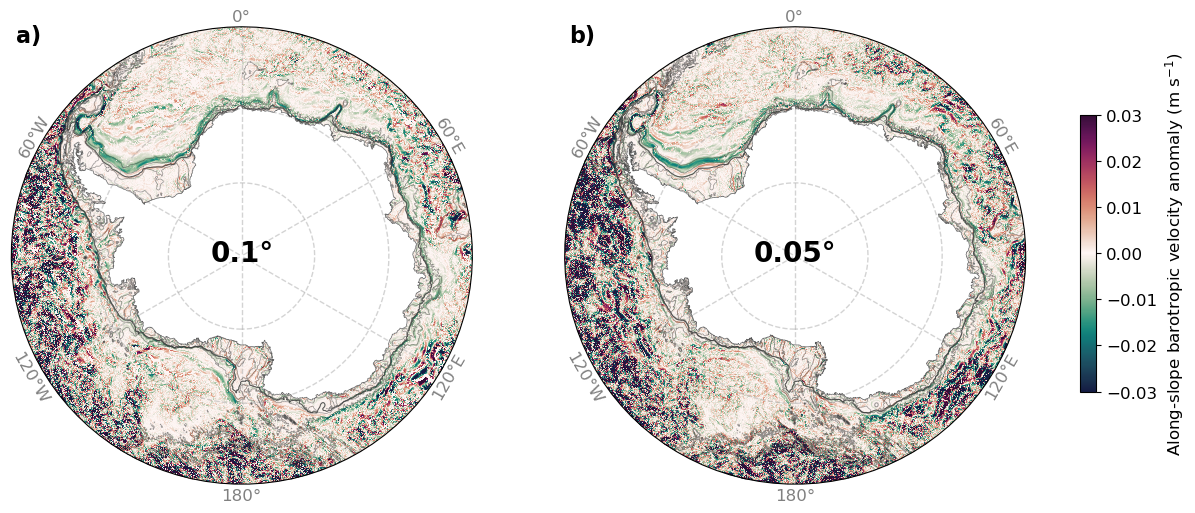

In [18]:
plt.rcParams['font.size'] = 18

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    subplot_kw={"projection": projection},
    figsize=(14, 6),
    constrained_layout=False
)

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
datasets = [data_1, data_2] 
land_masks = [land_1, land_2]
land_contours = [land_mask_1, land_mask_2]
shelf_masks = [shelf_contour_1, shelf_contour_2]
titles = ["0.1°", "0.05°"]
depths = [depth_1, depth_2]

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -57.5, -58, -58]

# Loop over subplots
for i, (ax, data, land_m, land_contour, shelf_m, title, depth) in enumerate(zip(
        axes, datasets, land_masks, land_contours, shelf_masks, titles, depths)):

    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines (keep as in original plot)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='darkgray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='darkgray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = data.plot(
        x="xh", y="yh",
        transform=ccrs.PlateCarree(),
        vmin=-0.03, vmax=0.03,
        extend="both",
        cmap=cm.cm.curl,
        add_colorbar=False,
        ax=ax,
    )

    # Depth contours
    depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                    colors='0.2', linewidths=[0.5, 0.75, 0.5, 0.5], alpha=0.5,
                    transform=ccrs.PlateCarree())

    # Titles
    ax.set_title("")
    ax.text(
        0.5, 0.5, title,
        transform=ax.transAxes,
        ha='center', va='center',
        fontsize=20, fontweight='bold',
        color='black', zorder=20
    )

    # Labels (a), (b)
    ax.text(0.01,1, f'{chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# Smaller shared colorbar on the right
cbar = fig.colorbar(
    im, ax=axes, orientation="vertical",
    fraction=0.015,  # smaller width
    aspect=17,       # longer and thinner
    shrink=0.8, pad=0.05
)
cbar.set_label("Along-slope barotropic velocity anomaly (m s$^{-1}$)", fontsize=12)
cbar.ax.tick_params(labelsize=12)  # tick font size

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_alongslopevelocity_maps.png", dpi=300, bbox_inches='tight')

# Quantifying

In [5]:
# Controls for percentage 
data_1_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_cont_pan01.nc', chunks = 'auto')
data_2_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_cont_pan005.nc', chunks = 'auto')

data_1_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_melt_pan01.nc', chunks = 'auto')
data_2_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/resolution_barotopic_slope_velocity_melt_pan005.nc', chunks = 'auto')

In [6]:
# Shelf mask

def shelf_mask_2500_isobath(var, model_dict):

    paths = {
            "mom5": '/g/data/g40/kc5856/access-om2-01-2500m-isobath-contour_masked_above.nc',
            "mom6_01": "/g/data/g40/kc5856/panant-01-2500m-isobath-contour_masked_above.nc",
            "mom6_005": "/g/data/g40/kc5856/panant-005-2500m-isobath-contour_masked_above.nc"
    }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask


In [7]:
depth_1_shelf, shelf_mask_1_2500 = shelf_mask_2500_isobath(depth_1, 'mom6_01')
depth_2_shelf, shelf_mask_2_2500 = shelf_mask_2500_isobath(depth_2, 'mom6_005')

Checking the mask is correct:

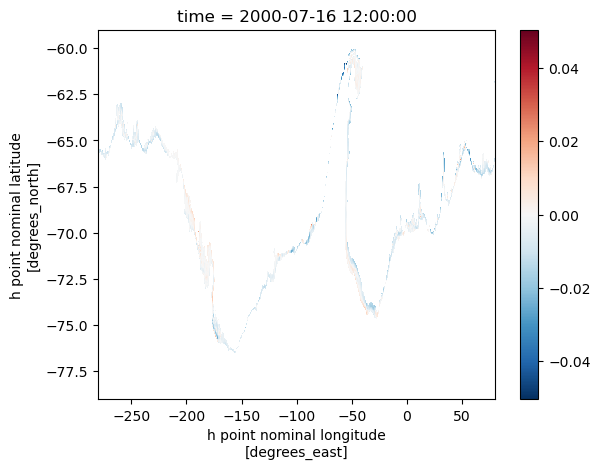

In [11]:
data_1.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).plot()

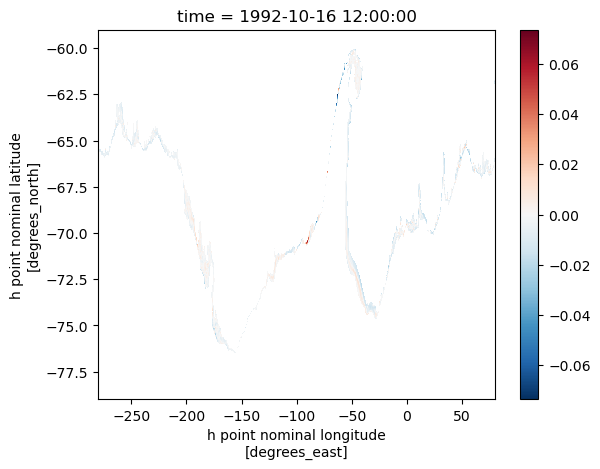

In [12]:
data_2.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).plot()

In [13]:
# Importing areas
# Areas for averaging
area_old_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
area_old_005 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['areacello']
var_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so']
var_005 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_month_z.nc')['so']
area_corr_01 = area_old_01*(var_01.isel(time=0,z_l=0)*0 +1)
area_corr_005 = area_old_005*(var_005.isel(time=0,z_l=0)*0 +1)

/jobfs/152932571.gadi-pbs/ipykernel_859943/3040758374.py:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  var_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so']
/jobfs/152932571.gadi-pbs/ipykernel_859943/3040758374.py:6: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will r

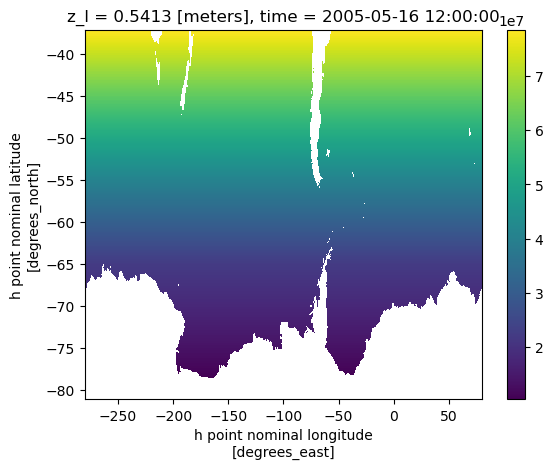

In [14]:
area_corr_01.plot()

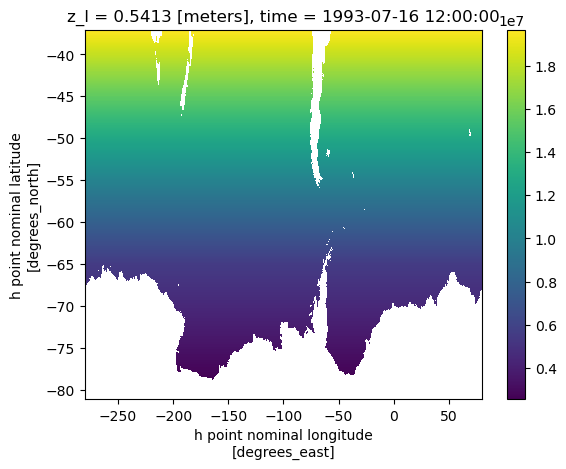

In [15]:
area_corr_005.plot()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


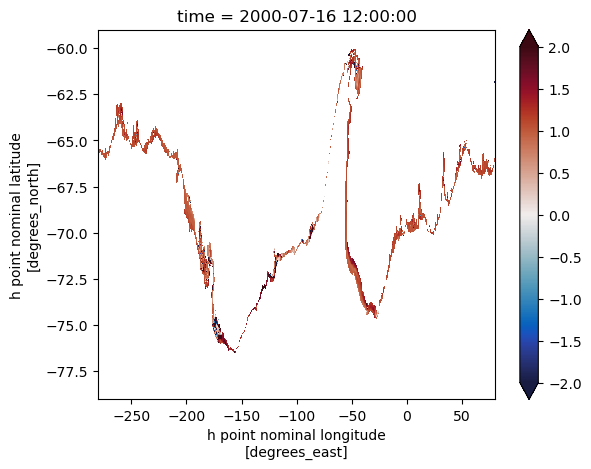

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [16]:
# Panant01
data_1_circ_all = (data_1_M.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)/data_1_C.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1))
data_1_circ_all.plot(vmin=-2,vmax=2,cmap=cm.cm.balance)

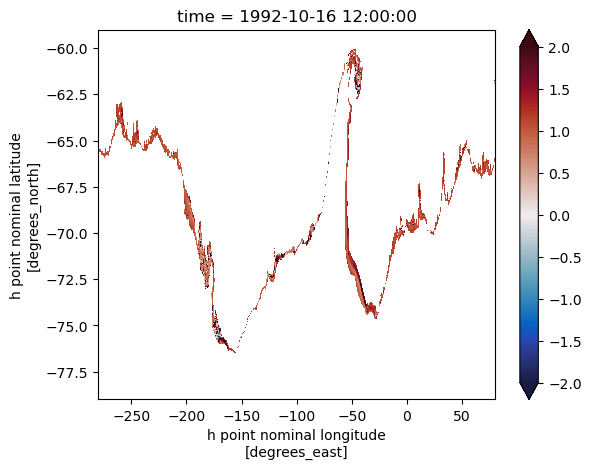

In [17]:
# ACCESS
data_2_circ_all = (data_2_M.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)/data_2_C.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1))
data_2_circ_all.plot(vmin=-2,vmax=2,cmap=cm.cm.balance)

In [18]:
# Spatial average
data_1_C_circ = (area_corr_01 * data_1_C.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_circ = (area_corr_01 * data_1_M.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_circ = (area_corr_005 * data_2_C.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])
data_2_M_circ = (area_corr_005 * data_2_M.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])

In [19]:
(data_1_M_circ/data_1_C_circ).load()

<xarray.DataArray ()> Size: 4B
array(1.1093123, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [20]:
(data_2_M_circ/data_2_C_circ).load()

<xarray.DataArray ()> Size: 4B
array(1.0976955, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 1993-07-16 12:00:00

In [32]:
# Spatial average
data_1_C_sect = (area_corr_01 * data_1_C.sel(xh=slice(-60,60)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-60,60)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_sect = (area_corr_01 * data_1_M.sel(xh=slice(-60,60)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-60,60)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_sect = (area_corr_005 * data_2_C.sel(xh=slice(-60,60)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-60,60)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])
data_2_M_sect = (area_corr_005 * data_2_M.sel(xh=slice(-60,60)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-60,60)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])

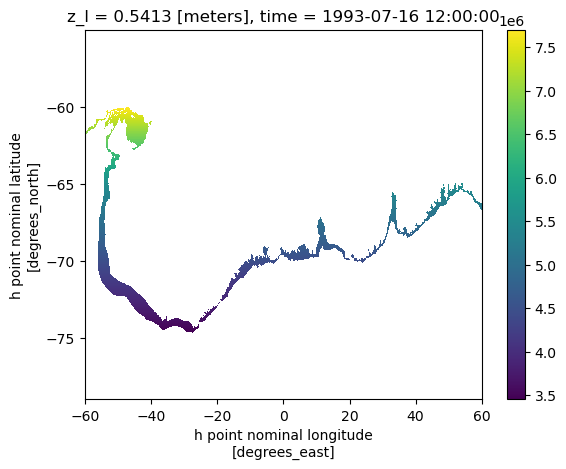

In [33]:
area_corr_005.sel(xh=slice(-60,60)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).plot()

In [34]:
(data_1_M_sect/data_1_C_sect).load()

<xarray.DataArray ()> Size: 4B
array(1.1098002, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [35]:
(data_2_M_sect/data_2_C_sect).load()

<xarray.DataArray ()> Size: 4B
array(1.1188151, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 1993-07-16 12:00:00

In [36]:
WeddellW = -65
WeddellE = 0

# Spatial average
data_1_C_We = (area_corr_01 * data_1_C.sel(xh=slice(-65,0)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-65,0)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_We = (area_corr_01 * data_1_M.sel(xh=slice(-65,0)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-65,0)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_We = (area_corr_005 * data_2_C.sel(xh=slice(-65,0)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-65,0)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])
data_2_M_We = (area_corr_005 * data_2_M.sel(xh=slice(-65,0)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-65,0)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])

In [37]:
(data_1_M_We/data_1_C_We).load()

<xarray.DataArray ()> Size: 4B
array(1.1265714, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [38]:
(data_2_M_We/data_2_C_We).load()

<xarray.DataArray ()> Size: 4B
array(1.1417272, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 1993-07-16 12:00:00

In [40]:
# West Antarctica
data_1_C_WA = (area_corr_01 * data_1_C.sel(xh=slice(-150,-65)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-150,-65)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_WA = (area_corr_01 * data_1_M.sel(xh=slice(-150,-65)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-150,-65)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_WA = (area_corr_005 * data_2_C.sel(xh=slice(-150,-65)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-150,-65)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])
data_2_M_WA = (area_corr_005 * data_2_M.sel(xh=slice(-150,-65)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-150,-65)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])

In [41]:
(1-data_1_M_WA/data_1_C_WA).load()

<xarray.DataArray ()> Size: 4B
array(0.3342769, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [42]:
(1-data_2_M_WA/data_2_C_WA).load()

<xarray.DataArray ()> Size: 4B
array(0.02140087, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 1993-07-16 12:00:00

In [43]:
# Ross Sea
data_1_C_Ro = (area_corr_01 * data_1_C.sel(xh=slice(-200,-150)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-200,-150)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_Ro = (area_corr_01 * data_1_M.sel(xh=slice(-200,-150)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-200,-150)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_Ro = (area_corr_005 * data_2_C.sel(xh=slice(-200,-150)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-200,-150)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])
data_2_M_Ro = (area_corr_005 * data_2_M.sel(xh=slice(-200,-150)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-200,-150)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])

In [44]:
(data_1_M_Ro/data_1_C_Ro).load()

<xarray.DataArray ()> Size: 4B
array(1.038277, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [45]:
(data_2_M_Ro/data_2_C_Ro).load()

<xarray.DataArray ()> Size: 4B
array(1.0500066, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 1993-07-16 12:00:00

In [46]:
# Adelie Coast
data_1_C_Ad = (area_corr_01 * data_1_C.sel(xh=slice(-280,-200)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-280,-200)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_Ad = (area_corr_01 * data_1_M.sel(xh=slice(-280,-200)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-280,-200)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_Ad = (area_corr_005 * data_2_C.sel(xh=slice(-280,-200)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-280,-200)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh']) 
data_2_M_Ad = (area_corr_005 * data_2_M.sel(xh=slice(-280,-200)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(-280,-200)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh']) 

In [47]:
(data_1_M_Ad/data_1_C_Ad).load()

<xarray.DataArray ()> Size: 4B
array(1.0644814, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [48]:
(data_2_M_Ad/data_2_C_Ad).load()

<xarray.DataArray ()> Size: 4B
array(1.0599461, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 1993-07-16 12:00:00

In [49]:
# Prydz Bay
data_1_C_Pr = (area_corr_01 * data_1_C.sel(xh=slice(0,80)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(0,80)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_Pr = (area_corr_01 * data_1_M.sel(xh=slice(0,80)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(0,80)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_Pr = (area_corr_005 * data_2_C.sel(xh=slice(0,80)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(0,80)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])
data_2_M_Pr = (area_corr_005 * data_2_M.sel(xh=slice(0,80)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xh', 'yh']) / area_corr_005.sel(xh=slice(0,80)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xh', 'yh'])

In [50]:
(data_1_M_Pr/data_1_C_Pr).load()

<xarray.DataArray ()> Size: 4B
array(1.1026944, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [51]:
(data_2_M_Pr/data_2_C_Pr).load()

<xarray.DataArray ()> Size: 4B
array(1.1001574, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 1993-07-16 12:00:00